In [1]:
import numpy as np
import pandas as pd
import pyflux as pf
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from linearmodels import PanelOLS
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [42]:
data = pd.read_csv('data_labels_user_id.csv')

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54775 entries, 0 to 54774
Columns: 1002 entries, user_id to labels
dtypes: int64(1001), object(1)
memory usage: 418.7+ MB


### Adjusting the total number of reads in proportion to their true activities in each sample.

In [44]:
data['total']=data.iloc[:,1:1001].sum(axis = 1) 
data1=data.iloc[:,1:1001].apply(lambda x: (x/data.total)*100)
data1.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.486,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,4.148,0.000,1.657,0.000,0.000,0.000,...,0.000,0.000,0.058,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,2.070,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


### Investigating underlying latent structure

First, I wanted to investigate whether there is an underlying latent structure and whether people fall into some groups in terms their microbiome. To do so, I conducted a principle component analysis. 

In [45]:
data1.corr()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000,-0.001,-0.002,-0.000,-0.001,-0.000,-0.001,-0.001,-0.000,-0.001,...,-0.000,-0.000,-0.001,-0.000,-0.000,-0.001,-0.000,-0.001,-0.000,-0.000
1,-0.001,1.000,-0.003,-0.006,0.015,0.007,-0.002,-0.004,-0.001,0.011,...,-0.003,0.013,0.000,0.004,0.013,-0.007,0.003,-0.018,0.006,0.001
2,-0.002,-0.003,1.000,0.006,0.011,-0.005,0.045,0.039,0.005,0.014,...,0.012,-0.005,0.041,-0.008,-0.010,0.025,0.009,-0.034,0.005,-0.005
3,-0.000,-0.006,0.006,1.000,-0.010,-0.001,0.063,-0.005,-0.000,-0.006,...,0.006,0.007,0.008,-0.002,-0.002,0.027,-0.003,-0.004,-0.001,-0.001
4,-0.001,0.015,0.011,-0.010,1.000,-0.003,-0.004,0.006,0.017,0.002,...,-0.000,0.006,0.008,0.002,0.006,-0.008,0.001,-0.015,-0.002,0.014
5,-0.000,0.007,-0.005,-0.001,-0.003,1.000,-0.002,-0.002,-0.000,0.002,...,-0.001,-0.001,-0.000,-0.001,0.001,-0.002,-0.001,-0.001,-0.000,0.002
6,-0.001,-0.002,0.045,0.063,-0.004,-0.002,1.000,0.012,-0.000,-0.001,...,0.003,0.006,0.013,-0.003,-0.004,0.018,0.000,-0.011,-0.001,-0.002
7,-0.001,-0.004,0.039,-0.005,0.006,-0.002,0.012,1.000,-0.001,0.006,...,0.008,-0.003,0.019,-0.003,-0.004,-0.000,-0.000,-0.013,0.007,-0.002
8,-0.000,-0.001,0.005,-0.000,0.017,-0.000,-0.000,-0.001,1.000,0.004,...,-0.000,-0.000,0.011,-0.000,-0.000,-0.001,-0.000,-0.001,-0.000,-0.000
9,-0.001,0.011,0.014,-0.006,0.002,0.002,-0.001,0.006,0.004,1.000,...,-0.003,-0.004,0.002,-0.004,0.003,0.002,0.006,-0.018,-0.002,-0.002


At the first glance, it does not look like the correlational matrix above is generous with correlations. But I would not know as I cannot manually look over the correlations of thousand variables. I will continue with PCA.

### PCA

In [68]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(data1)
covMat = np.cov(X_scaled.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

print (len(eigenValues))
print (len(eigenVectors))

1000
1000


In [7]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()

for i,b in eigenPairs:
    if i>2:
        print(i)

8.619048476580376
7.01761361677236
6.370054554079409
4.794120152101966


In [8]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]

print(varExpl[:20])

[0.8618891122888415, 0.7017485499682131, 0.636993825915372, 0.4794032628228804, 0.1491317919458284, 0.1411764664444994, 0.1379011612482623, 0.13593981477157333, 0.13546497494141002, 0.13361846484826637, 0.13277534289664447, 0.13229639831894482, 0.13091363806144576, 0.13029832622856943, 0.12970479509745617, 0.1286050896547995, 0.1278948152187206, 0.12776358790731204, 0.1274610766282042, 0.12726500274032393]


In [9]:
cvarex = np.cumsum(varExpl);
cvarex[:20]

array([0.86188911, 1.56363766, 2.20063149, 2.68003475, 2.82916654,
       2.97034301, 3.10824417, 3.24418399, 3.37964896, 3.51326743,
       3.64604277, 3.77833917, 3.9092528 , 4.03955113, 4.16925593,
       4.29786102, 4.42575583, 4.55351942, 4.6809805 , 4.8082455 ])

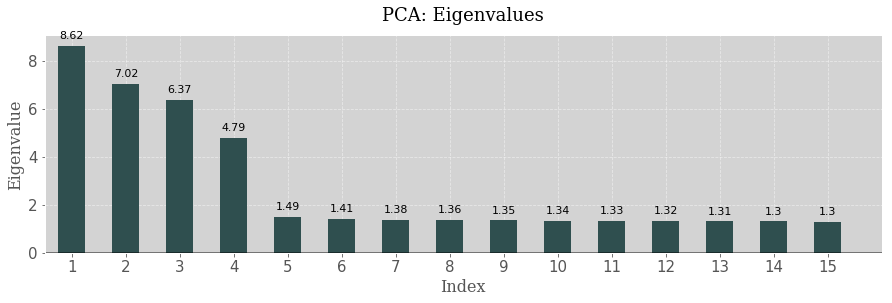

In [11]:
plt.style.use('ggplot')


eigs = pd.DataFrame(eigenValues)
egigs=eigs.sort_values(by=0, ascending=False)[:15]

plt.rcParams['axes.facecolor'] = 'lightgrey'


ax=egigs.plot.bar(color = 'darkslategrey',legend=None,figsize=(15,4))
plt.title('PCA: Eigenvalues', fontsize = 18, y = 1.04,family='serif')
plt.ylabel('Eigenvalue', fontsize = 16,family='serif')
plt.xlabel('Index', fontsize = 16,family='serif')
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(range(-1, len(egigs)), rotation=0, fontsize = 15)
for i, label in enumerate(list(egigs.index)):
    score = egigs.ix[label][0].round(2)
    ax.annotate(str(score), (i, score + .3),ha='center', size=11) 
ax.set_xticklabels(range(0,18))
plt.yticks(fontsize = 15)
plt.xlim([-.5, len(egigs)])
plt.grid(color='white', linestyle='--', alpha=.5)
plt.show()

It looks like I was able to identify 4 main eigenvalues above.

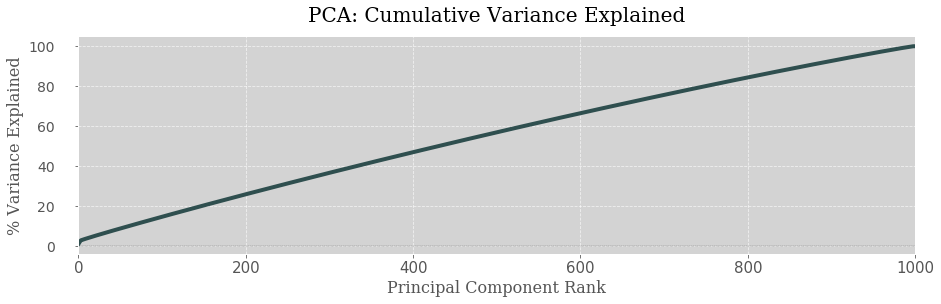

In [12]:
leng = pd.DataFrame(cvarex)
plt.style.use('ggplot')


plt.rcParams['axes.facecolor'] = 'lightgrey'

plt.figure(figsize=(15,4))
ax = plt.gca()
ax.set_ylabel('% Variance Explained', fontsize=16,family='serif' )
ax.set_xlabel('Principal Component Rank', fontsize=16,family='serif')

ax.set_title('PCA: Cumulative Variance Explained',\
             fontsize=20, y = 1.04,family='serif' )

ax.plot(cvarex, color = 'darkslategrey', linewidth = 4)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim([-.5, len(leng)])
ax.tick_params(axis='y', which='major', pad=20,labelsize=14)
plt.axhline(0, color='black', alpha = 0.5, linewidth = .4,linestyle='--')
plt.axvline(0, color='black', alpha = 0.5, linewidth = .4,linestyle='--')
plt.grid(color='white', linestyle='--', alpha=.7)
plt.show()

However, these components do not explain at least 70 to 80% of the variance. As Principle Component Rank increases, percentage of variance explained increases as well. There is no break in the graph above. Interesting. It looks like each person has a unique microbiome. Are our guts really that diverse? I am going to try to do some clustering in order to confirm my PCA findings: (http://ranger.uta.edu/~chqding/papers/KmeansPCA1.pdf)

### K-means clustering

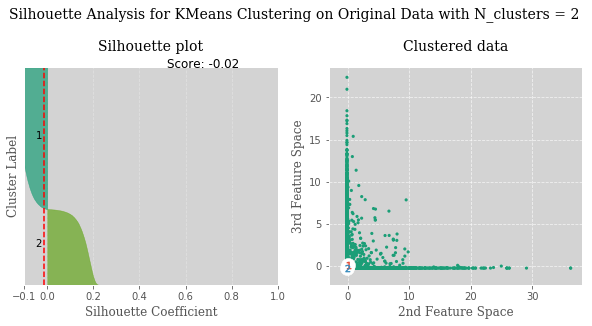

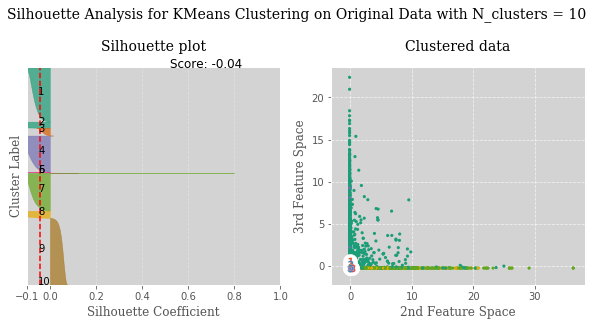

In [14]:
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.cluster import KMeans

X=X_scaled

range_n_clusters = [2,10]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters)
    labels= clusterer.fit(X)
    cluster_labels=labels.labels_


    silhouette_avg = silhouette_score(X, cluster_labels)
    ax1.annotate('Score: %.2f' % silhouette_avg, xy=(1, 5), xytext=(0.52, 50),\
                 fontsize=12)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.Dark2(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
        y_lower = y_upper + 10 

    ax1.set_title("Silhouette plot",fontsize=14, y=1.05,family='serif')
    ax1.set_xlabel("Silhouette Coefficient",fontsize=12,family='serif')
    ax1.set_ylabel("Cluster Label",fontsize=12,family='serif')
    

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.grid(color='white', linestyle='--', alpha=.3)
    ax1.invert_yaxis()

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

 
    colors = plt.cm.Dark2(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 1], X[:, 2], marker='.', s=40, lw=0,
                c=colors)
    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 1], centers[:, 2],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[1], c[2], marker='$%d$' % (i+1), alpha=1, s=50)



    ax2.set_title("Clustered data", fontsize=14, y=1.05,family='serif')
    ax2.set_xlabel("2nd Feature Space",fontsize=12,family='serif')
    ax2.set_ylabel("3rd Feature Space",fontsize=12,family='serif')
    ax2.grid(color='white', linestyle='--', alpha=.7)

    plt.suptitle(("Silhouette Analysis for KMeans Clustering on Original Data "
                  "with N_clusters = %d" % n_clusters),
                 fontsize=14, y=1.09,family='serif')

    plt.show()

As you can see above there is a zero cohesion and separation in the data. That’s it does not look like there is any underlying latent structure and it seems that each subject in the sample has a unique microbiome. 

### Lasso Logistic Regression

What are my options in terms of analyzing the data now? I cannot reduce dimensionality of my data, and even if I could I would not know how each variable contributes to the outcome. I have high dimensional sparse data with one thousand variables. One solutions would be to conduct a step-wise logistic regression. There is no package in Python that does variable selection for a regression automatically. The package can be written but it takes time. There is a package in R called Glmulti that does that but when I’ve tried to install it asked me to install Java, and for security reasons, I had to pass on installing Java on my laptop. My decision was to conduct a Lasso logistic regression in Python. Although, the Lasso regression does not provide p-value for each coefficient (I would have to go through a tedious bootstrapping), it performs very well when it comes to variable selection. P-values are highly overrated anyway. Also, I can estimate log odds for each coefficient which can be a valuable information on its own. 

In [52]:
from sklearn.linear_model import LogisticRegression
X=X_scaled
y=data['labels'].values
lg= LogisticRegression(penalty='l2',C=.5,random_state=10)
lg.fit(X,y)
LassoResult=lg.coef_
coef_list = [i for i in LassoResult.tolist()][0]
odds_list=[np.exp(i) for i in LassoResult.tolist()][0]
len([i for i in LassoResult.tolist()][0])

1000

In [53]:
len(coef_list)

1000

We can see below that Lasso regression shrunk less significant coefficients to zero while stressing more important coefficients. 

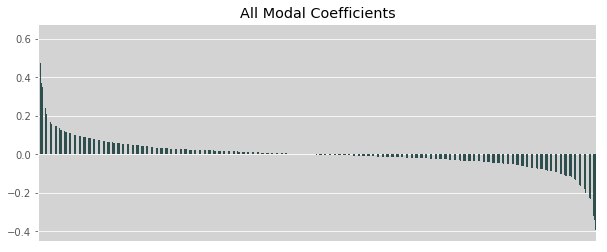

In [54]:
plt.style.use('ggplot')
plt.figure(figsize=(10,4))
predictors = data.iloc[:,1:1001].columns

coef = pd.Series(coef_list, predictors).sort_values(ascending=False)
ax=coef.plot(kind='bar', title='All Modal Coefficients',\
             color='darkslategrey')
ax.set_facecolor('lightgrey')
ax.get_xaxis().set_ticks([])
plt.show()


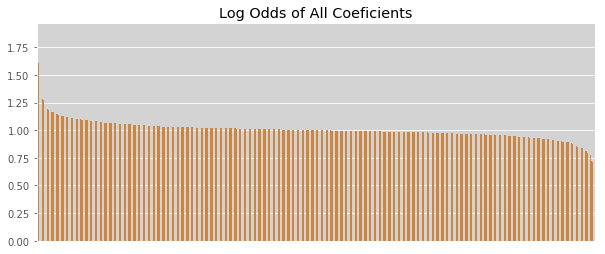

In [55]:
plt.figure(figsize=(10,4))
predictors = data.iloc[:,1:1001].columns
odds = pd.Series(odds_list,predictors).sort_values(ascending=False)
ax=odds.plot(kind='bar', title='Log Odds of All Coeficients', color='peru')
ax.set_facecolor('lightgrey')
ax.get_xaxis().set_ticks([])

plt.show()

In [56]:
log_odds_up=odds.loc[odds >1.12]
log_odds_down=odds.loc[odds<.90].sort_values()

print (len(log_odds_up))
print (len(log_odds_down))

53
59


Now we can estimate log odds and interpret the coefficients. For example, presence of the microbe # 435 in a stool indicates approximately 78% increase in the odds of having the disease. While presence of microbe # 431 indicates approximately 32% decrease in the odds of having the disease. Please see the graphs below:

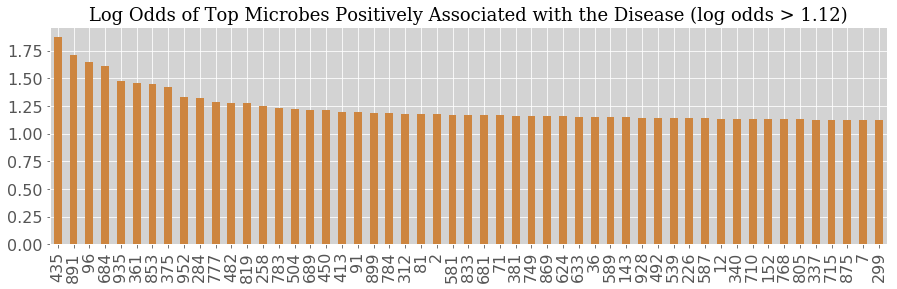

In [57]:
plt.figure(figsize=(15,4))

ax=log_odds_up.plot(kind='bar', \
                 color='peru', fontsize=16)

ax.set_title("Log Odds of Top Microbes \
Positively Associated with the Disease (log odds > 1.12)",\
                  x=.5, fontsize=18,family='serif')
ax.set_facecolor('lightgrey')
plt.show()

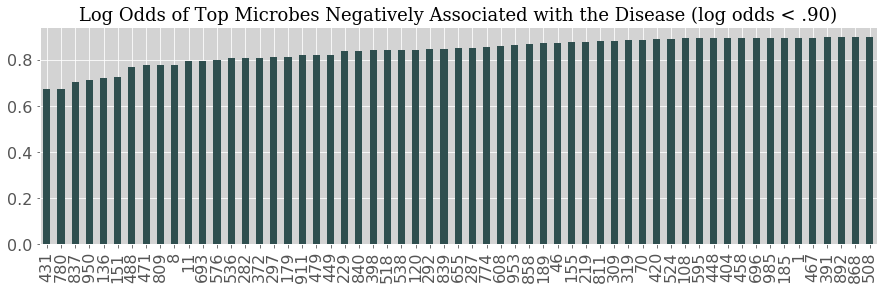

In [23]:

plt.figure(figsize=(15,4))

ax=log_odds_down.plot(kind='bar', \
                 color='darkslategrey', fontsize=16)

ax.set_title("Log Odds of Top Microbes \
Negatively Associated with the Disease (log odds < .90)",\
                  x=.5, fontsize=18,family='serif')
ax.set_facecolor('lightgrey')
plt.show()

### Feature Selection

We can build a machine learning model predicting the outcome of the disease based on the presence of various microbe. First, I would like to perform an automatic feature selection. Note, I am fitting the whole sample because I am still not training and testing my model. I am just trying to identify which features are more important in predicting the outcome based on the whole sample. This way, I am trying to avoid overfitting of my actual machine learning model. I will use Random Forest and Decision Tree and I will avoid any bagging and boosting algorithms as it will take a long time to run those models with the number of features I have.

In [69]:
X=X_scaled
y=data['labels'].values

Random Forest Score:	0.701 ± 0.004
Decision Tree Score:	0.676 ± 0.006


,Random Forest,Decision Tree
891,0.010,0.017
853,0.009,0.012
431,0.008,0.012
780,0.008,0.012
935,0.007,0.010
375,0.007,0.009
11,0.007,0.007
488,0.007,0.009
136,0.007,0.009
151,0.006,0.010


None


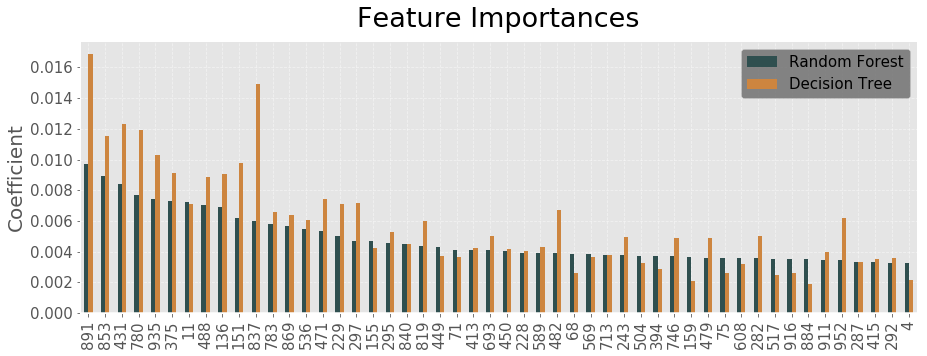

In [71]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from IPython.display import display, HTML

# plt.style.use('bmh')
plt.style.use('ggplot')
rf = RandomForestClassifier(random_state=10)
dtc = DecisionTreeClassifier(random_state=10)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=78)
def score(model, name):
    s = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print ("{} Score:\t{:0.3} ± {:0.3}".format\
           (name, s.mean().round(3), s.std().round(3)))

score(rf,"Random Forest")
score(dtc, "Decision Tree")

rf.fit(X, y)
dtc.fit(X, y)

importances = pd.DataFrame(list(zip(rf.feature_importances_,
                               dtc.feature_importances_,
                              )),
                           index=data.iloc[:,1:1001].columns,
                           columns=['Random Forest',
                                    'Decision Tree',
                                   ]).sort_values('Random Forest',
                                                                  ascending=False)

print (display(importances.head(50)))



importances[0:50].plot(kind='bar', figsize=(15,5), color=['darkslategrey','peru'])

plt.grid(color='white', linestyle='--', alpha=.5)
plt.rcParams['axes.facecolor'] = 'dimgrey'
plt.title('Feature Importances', fontsize = 27, y = 1.03, color='black')
plt.ylabel('Coefficient', fontsize = 20)
plt.yticks(fontsize = 15)

#plt.xlabel('Features', fontsize = 30)
plt.axhline(0, color='white')
plt.xticks(rotation=90, fontsize = 15)
plt.legend(loc='upper right', fontsize=15)
plt.show()

I will pick my features based on the Random Forest Algorithm result. I will select the features with coefficient of importance higher than 0.0001. It is just arbitrary and, possibly, it can be played around with if more time is given. So far, this arbitrary decision gave me the best accuracy score across all models. 

### Building a Machine Learning Model

In [59]:
df1=importances.loc[importances['Random Forest'] >0.0001]
lst=list(df1.index)
len(list(df1.index))

785

In [60]:
df = data1[data1.columns.intersection(lst)]

In [61]:
df1=pd.concat([df, data['labels']],axis=1)

In [62]:
X_scaled = StandardScaler().fit_transform(df1.iloc[:, :-1])
X=X_scaled 
y=df1['labels'].values

In [63]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.6,
                                                    random_state=10,
                                                    stratify=y)

In [64]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression



cv_train = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
cv_test = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

lg= LogisticRegression(penalty='l1',random_state=10, C=.5)
dt = DecisionTreeClassifier(class_weight='balanced',min_samples_split=50,random_state=10)
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1,random_state=10)
bnb = BernoulliNB()





def score(model, name):
    train_score = cross_val_score(model, X_train, y_train, cv=cv_train, n_jobs=-1)
    print ("{} Training Accuracy Score:\t{:0.3} ± {:0.3}".format(name, train_score.mean().round(3),\
                                                                train_score.std().round(3)))

        
score(dt,"Decision Tree")
score(lg, "Logistic Regres")
score(rf, "Random Forest")
score(bnb, "Bernoulli NB")

Decision Tree Training Accuracy Score:	0.629 ± 0.01
Logistic Regres Training Accuracy Score:	0.786 ± 0.007
Random Forest Training Accuracy Score:	0.68 ± 0.009
Bernoulli NB Training Accuracy Score:	0.573 ± 0.008


We can see that Lasso regression still is the best performer when it comes to the accuracy of predicting the outcome. I would pick this model. Probably, if I had time I would tune it better (if I had more time), but for now,  this model outperform the others. 

In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



lg.fit(X_train, y_train)

test_acc = accuracy_score(y_true=y_test, y_pred=lg.predict(X_test))

print('Test Accuracy: %.2f%%' % (100 * test_acc))

Test Accuracy: 78.69%


In [66]:
y_pred_test=lg.predict(X_test)


print('Test Accuracy: %.2f%%' % (100 * test_acc))
print ()
print ('Confusion Matrix')
print (classification_report(y_test, y_pred_test))

Test Accuracy: 78.69%

Confusion Matrix
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      9709
           1       0.80      0.82      0.81     12201

   micro avg       0.79      0.79      0.79     21910
   macro avg       0.78      0.78      0.78     21910
weighted avg       0.79      0.79      0.79     21910



I think my machine learning model performs relatively well. At least precision (80%) and recall (82%) of predicting the disease are looking good relatively to each other. Of course, a higher prediction score is something to strive for. 

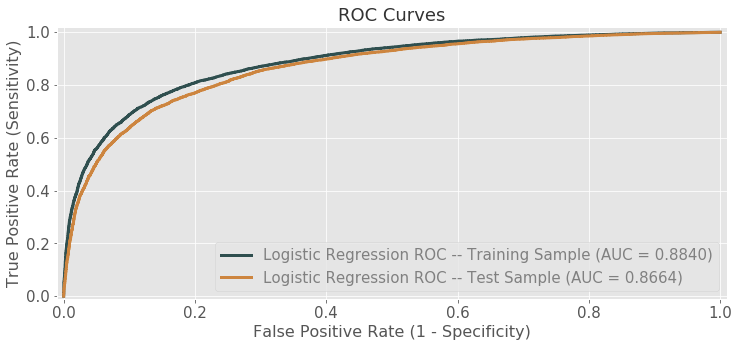

In [67]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


plt.style.use(['ggplot'])

plt.figure(figsize=(12,5))

y_pred_train = lg.predict_proba(X_train)[:,1]
y_pred_test = lg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_train)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred_test)



ROC_AUC = auc(fpr, tpr)
ROC_AUC1 = auc(fpr1, tpr1)


plt.plot(fpr, tpr, label='Logistic Regression ROC -- Training Sample (AUC = %0.4f)' % ROC_AUC,color='darkslategrey', linewidth=3)
plt.plot(fpr1, tpr1, label='Logistic Regression ROC -- Test Sample (AUC = %0.4f)' % ROC_AUC1, color='peru',linewidth=3)



plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.02])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=16)
plt.ylabel('True Positive Rate (Sensitivity)',fontsize=16)

l=plt.legend(loc='lower right', fontsize=15)
for text in l.get_texts():
    text.set_color("gray")

plt.title('ROC Curves', color="black", alpha=0.8,fontsize=18)
plt.show()